# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train__2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(25192, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

    
preprocess.x_train.std()

0.97509982675167528

In [6]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, LSTMCell, MultiRNNCell


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x_input = tf.placeholder("float", shape=[None, 1, input_dim])
            self.y_input_ = tf.placeholder("float", shape=[None, 1, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
            self.x_list = tf.unstack(self.x_input, axis= 1)
            self.y_list_ = tf.unstack(self.y_input_, axis = 1)
            self.y_ = self.y_list_[0]
            
            #GO = tf.fill((tf.shape(self.x)[0], 1), 0.5)
            
            #y_with_GO = tf.stack([self.y_, GO])
            
        with tf.variable_scope("lstm"):
            multi_cell = MultiRNNCell([LSTMCell(input_dim) for i in range(hidden_layers)] )
            
            self.y, states = basic_rnn_seq2seq(self.x_list, self.y_list_, multi_cell)
            #self.y = tf.slice(self.y, [0, 0], [-1,2])
            
            #self.out = tf.squeeze(self.y)
            
            #self.y = tf.layers.dense(self.y[0], classes, activation = None)
            
            self.y = tf.slice(self.y[0], [0, 0], [-1,2])
            
        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.y_, self.y)
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

batch_iterations = 200

x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
for i in batch_indices:
    print(x_train[i,np.newaxis,:])
    print(y_train[i,np.newaxis,:])

In [8]:
import collections
import sklearn.metrics as me

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'test_score_20', 'f1_score_20', 'time_taken'])

    predictions = {}
    predictions_ = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_lstm_nsl_kdd-orig-/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            
            accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                             net.keep_prob:1})
            
            print("Initial Accuracy, before training: {}".format(accuracy))
            
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        _, train_loss = sess.run([net.train_op, net.regularized_loss], #net.summary_op
                                                              feed_dict={net.x_input: x_train[i,np.newaxis,:], 
                                                                         net.y_input_: y_train[i,np.newaxis,:], 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_train.add_summary(summary_str, epoch)
                        if(train_loss > 1e9):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))


                    valid_accuracy,valid_loss = sess.run([net.tf_accuracy, net.regularized_loss], #net.summary_op 
                                                          feed_dict={net.x_input: x_valid[:,np.newaxis,:], 
                                                                     net.y_input_: y_valid[:,np.newaxis,:], 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)



                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test[:,np.newaxis,:], 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score = me.f1_score(actual_value, pred_value)
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x_input: preprocess.x_test_[:,np.newaxis,:], 
                                                                             net.y_input_: preprocess.y_test_[:,np.newaxis,:], 
                                                                             net.keep_prob:1, net.lr:lr})
                    f1_score_ = me.f1_score(actual_value_, pred_value_)
                    print("Step {} | Training Loss: {:.6f} | Train Accuracy: {:.6f} | Test Accuracy: {:.6f}, {:.6f}".format(epoch, train_loss, valid_accuracy, accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                                Train.best_acc_global = accuracy
                                Train.pred_value = pred_value
                                Train.actual_value = actual_value
                                Train.pred_value_ = pred_value_
                                Train.actual_value_ = actual_value_
                                Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:

                        #net.saver.save(sess, "dataset/tf_vae_only_nsl_kdd_hidden layers_{}_features count_{}".format(epochs,h,f))
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
                        #curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
                        #Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})

                        Train.best_acc = accuracy
                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_lstm_nsl_kdd-orig-/hidden layers_{}_features count_{}/model"
                                       .format(h,f), 
                                       global_step = epoch, 
                                       write_meta_graph=False)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        curr_pred_ = pd.DataFrame({"Attack_prob":y_pred_[:,-2], "Normal_prob":y_pred_[:, -1], "Prediction":pred_value_})
                        Train.predictions.update({"{}_{}_{}".format((epochs+1)* (c+1),f,h):
                                                  (curr_pred,
                                                   Train.result((epochs+1)*(c+1), f, h,valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})
                        Train.predictions_.update({"{}_{}_{}".format((epochs+1)* (c+1),f,h):
                                                  (curr_pred_,
                                                   Train.result((epochs+1)*(c+1), f, h,valid_accuracy, accuracy, f1_score, accuracy_, f1_score_, time.perf_counter() - start_time))})



            

In [9]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [1] #[4, 8, 16, 32]
        hidden_layers_arr = [1, 3]

        epochs = [10]
        lrs = [1e-2, 1e-3]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict1_ = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)

        for k, (v1_, v2) in Train.predictions.items():
            dict1_.update({k: v1_})

            
        Train.predictions = dict1
        Train.predictions_ = dict1_

        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_lstm_nsl_kdd-orig_all-.pkl'):
            past_scores = temp
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all-.pkl")

        past_scores.append(temp).to_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all-.pkl")


In [10]:
%%timeit -r 10

Hyperparameters.start_training()

Current Layer Attributes - epochs:10 hidden layers:1 features count:1
Initial Accuracy, before training: 0.6701561212539673
Step 1 | Training Loss: 0.003627 | Train Accuracy: 0.989683 | Test Accuracy: 0.798882, 0.617384
Step 2 | Training Loss: 0.002081 | Train Accuracy: 0.998810 | Test Accuracy: 0.827670, 0.672152
Step 3 | Training Loss: 0.002216 | Train Accuracy: 1.000000 | Test Accuracy: 0.848164, 0.711139
Step 4 | Training Loss: 0.001697 | Train Accuracy: 1.000000 | Test Accuracy: 0.878815, 0.769451
Step 5 | Training Loss: 0.002121 | Train Accuracy: 1.000000 | Test Accuracy: 0.888041, 0.787004
Step 6 | Training Loss: 0.000990 | Train Accuracy: 1.000000 | Test Accuracy: 0.899175, 0.808186
Step 7 | Training Loss: 0.001240 | Train Accuracy: 1.000000 | Test Accuracy: 0.882275, 0.776034
Step 8 | Training Loss: 0.001218 | Train Accuracy: 1.000000 | Test Accuracy: 0.878194, 0.768270
Step 9 | Training Loss: 0.001478 | Train Accuracy: 1.000000 | Test Accuracy: 0.896026, 0.802194
Step 10 | Tr

Initial Accuracy, before training: 0.3531759977340698
Step 1 | Training Loss: 0.013891 | Train Accuracy: 0.988095 | Test Accuracy: 0.781583, 0.584473
Step 2 | Training Loss: 0.002480 | Train Accuracy: 0.998413 | Test Accuracy: 0.837917, 0.691646
Step 3 | Training Loss: 0.003878 | Train Accuracy: 0.999603 | Test Accuracy: 0.873181, 0.758734
Step 4 | Training Loss: 0.001976 | Train Accuracy: 0.999603 | Test Accuracy: 0.881742, 0.775021
Step 5 | Training Loss: 0.001798 | Train Accuracy: 1.000000 | Test Accuracy: 0.902014, 0.813586
Step 6 | Training Loss: 0.001708 | Train Accuracy: 1.000000 | Test Accuracy: 0.916962, 0.842025
Step 7 | Training Loss: 0.001443 | Train Accuracy: 1.000000 | Test Accuracy: 0.914434, 0.837215
Step 8 | Training Loss: 0.002534 | Train Accuracy: 1.000000 | Test Accuracy: 0.913369, 0.835190
Step 9 | Training Loss: 0.000698 | Train Accuracy: 1.000000 | Test Accuracy: 0.918559, 0.845063
Step 10 | Training Loss: 0.001226 | Train Accuracy: 1.000000 | Test Accuracy: 0.91

Step 1 | Training Loss: 0.014180 | Train Accuracy: 0.992063 | Test Accuracy: 0.781849, 0.584979
Step 2 | Training Loss: 0.003658 | Train Accuracy: 1.000000 | Test Accuracy: 0.860406, 0.734430
Step 3 | Training Loss: 0.001256 | Train Accuracy: 0.999206 | Test Accuracy: 0.893009, 0.796456
Step 4 | Training Loss: 0.001298 | Train Accuracy: 1.000000 | Test Accuracy: 0.896780, 0.803629
Step 5 | Training Loss: 0.001283 | Train Accuracy: 1.000000 | Test Accuracy: 0.892965, 0.796371
Step 6 | Training Loss: 0.002811 | Train Accuracy: 1.000000 | Test Accuracy: 0.906450, 0.822025
Step 7 | Training Loss: 0.001033 | Train Accuracy: 1.000000 | Test Accuracy: 0.899441, 0.808692
Step 8 | Training Loss: 0.000738 | Train Accuracy: 1.000000 | Test Accuracy: 0.897534, 0.805063
Step 9 | Training Loss: 0.000968 | Train Accuracy: 1.000000 | Test Accuracy: 0.898421, 0.806751
Step 10 | Training Loss: 0.001177 | Train Accuracy: 1.000000 | Test Accuracy: 0.898953, 0.807764
Step 1 | Training Loss: 0.000692 | Trai

Step 2 | Training Loss: 0.002226 | Train Accuracy: 0.997222 | Test Accuracy: 0.829090, 0.674852
Step 3 | Training Loss: 0.001995 | Train Accuracy: 0.997619 | Test Accuracy: 0.838760, 0.693249
Step 4 | Training Loss: 0.004410 | Train Accuracy: 0.998413 | Test Accuracy: 0.845813, 0.706667
Step 5 | Training Loss: 0.002442 | Train Accuracy: 0.999206 | Test Accuracy: 0.860140, 0.733924
Step 6 | Training Loss: 0.002720 | Train Accuracy: 0.999603 | Test Accuracy: 0.862092, 0.737637
Step 7 | Training Loss: 0.001091 | Train Accuracy: 1.000000 | Test Accuracy: 0.866661, 0.746329
Step 8 | Training Loss: 0.001547 | Train Accuracy: 1.000000 | Test Accuracy: 0.891501, 0.793586
Step 9 | Training Loss: 0.001018 | Train Accuracy: 1.000000 | Test Accuracy: 0.886844, 0.784726
Step 10 | Training Loss: 0.001457 | Train Accuracy: 1.000000 | Test Accuracy: 0.890836, 0.792321
Step 1 | Training Loss: 0.001209 | Train Accuracy: 1.000000 | Test Accuracy: 0.882984, 0.777384
Step 2 | Training Loss: 0.000964 | Trai

Step 3 | Training Loss: 0.001206 | Train Accuracy: 0.998810 | Test Accuracy: 0.871141, 0.754852
Step 4 | Training Loss: 0.001779 | Train Accuracy: 1.000000 | Test Accuracy: 0.877484, 0.766920
Step 5 | Training Loss: 0.000848 | Train Accuracy: 1.000000 | Test Accuracy: 0.895094, 0.800422
Step 6 | Training Loss: 0.003481 | Train Accuracy: 1.000000 | Test Accuracy: 0.893941, 0.798228
Step 7 | Training Loss: 0.001490 | Train Accuracy: 1.000000 | Test Accuracy: 0.895626, 0.801435
Step 8 | Training Loss: 0.000955 | Train Accuracy: 1.000000 | Test Accuracy: 0.896602, 0.803291
Step 9 | Training Loss: 0.001212 | Train Accuracy: 1.000000 | Test Accuracy: 0.898776, 0.807426
Step 10 | Training Loss: 0.000701 | Train Accuracy: 1.000000 | Test Accuracy: 0.894296, 0.798903
Step 1 | Training Loss: 0.001183 | Train Accuracy: 1.000000 | Test Accuracy: 0.893453, 0.797300
Step 2 | Training Loss: 0.000926 | Train Accuracy: 1.000000 | Test Accuracy: 0.893142, 0.796709
Step 3 | Training Loss: 0.001251 | Trai

Step 4 | Training Loss: 0.001456 | Train Accuracy: 0.999603 | Test Accuracy: 0.895360, 0.800928
Step 5 | Training Loss: 0.000962 | Train Accuracy: 0.999603 | Test Accuracy: 0.883162, 0.777722
Step 6 | Training Loss: 0.001419 | Train Accuracy: 0.999603 | Test Accuracy: 0.890658, 0.791983
Step 7 | Training Loss: 0.001322 | Train Accuracy: 1.000000 | Test Accuracy: 0.892078, 0.794684
Step 8 | Training Loss: 0.000702 | Train Accuracy: 1.000000 | Test Accuracy: 0.897844, 0.805654
Step 9 | Training Loss: 0.001515 | Train Accuracy: 1.000000 | Test Accuracy: 0.894517, 0.799325
Step 10 | Training Loss: 0.001324 | Train Accuracy: 1.000000 | Test Accuracy: 0.892300, 0.795105
Step 1 | Training Loss: 0.001038 | Train Accuracy: 1.000000 | Test Accuracy: 0.891102, 0.792827
Step 2 | Training Loss: 0.000704 | Train Accuracy: 1.000000 | Test Accuracy: 0.890924, 0.792489
Step 3 | Training Loss: 0.000687 | Train Accuracy: 1.000000 | Test Accuracy: 0.891191, 0.792996
Step 4 | Training Loss: 0.001183 | Trai

In [11]:
g = df_results.groupby(by=['no_of_features'])
idx = g['test_score'].transform(max) == df_results['test_score']
df_results[idx].sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,test_score_20,f1_score_20,time_taken
1,11,1,3,1.0,1.0,1.0,1.0,1.0,15.237297


In [12]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,f1_score,test_score_20,f1_score_20,time_taken
1,11,1,3,1.0,1.000000,1.000000,1.000000,1.000000,15.237297
0,11,1,1,1.0,0.897844,0.906195,0.805654,0.874022,9.943235


In [13]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_lstm_nsl_kdd_predictions-.pkl")
pd.Panel(Train.predictions_).to_pickle("dataset/tf_lstm_nsl_kdd_predictions-__.pkl")

df_results.to_pickle("dataset/tf_lstm_nsl_kdd_scores-.pkl")

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = False,
                         title = Train.best_parameters)

Confusion matrix, without normalization
[[ 9711     0]
 [    0 12833]]


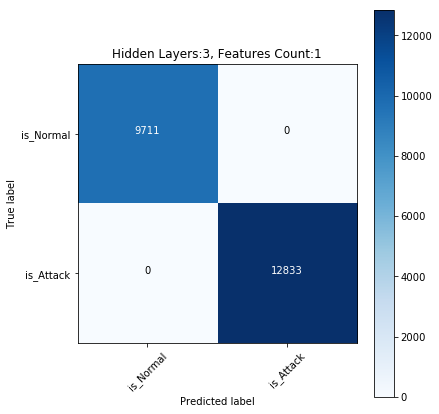

In [15]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

Confusion matrix, without normalization
[[2152    0]
 [   0 9698]]


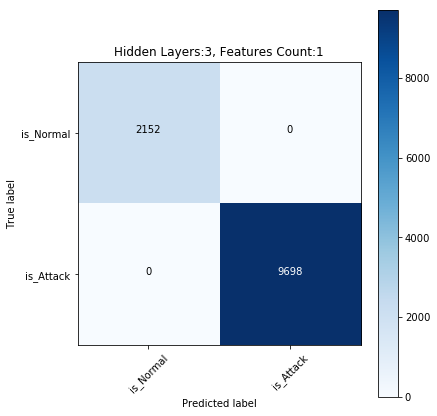

In [16]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

In [17]:
#4.5 GB
pd.Series(Train.pred_value).to_csv('LSTM_prediction_values.csv')

In [18]:
past_scores

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                             
1              1                 11     1.000000    0.899175  0.907590   
               3                 11     0.999206    0.980704  0.983254   
               1                 11     1.000000    0.899175  0.907590   
               3                 11     0.999206    0.980704  0.983254   
               1                 11     1.000000    0.903699  0.912080   
               3                 11     1.000000    0.999734  0.999766   
               1                 11     1.000000    0.918559  0.924326   
               3                 11     1.000000    0.999734  0.999766   
               1                 11     1.000000    0.897667  0.905940   
               3                 11     1.000000    0.993701  0.994492   
               3                 22     1.000000    0.994633  0.995302   
               1                 11     1.000000    0.906450  0.914591   
               3                 11     1.000000    0.999290  0.999377   
               1                 11     1.000000    0.899574  0.908087   
               3                 11     1.000000    0.986914  0.988427   
               1                 11     1.000000    0.891501  0.899655   
               3                 11     1.000000    0.976579  0.979063   
               1                 11     1.000000    0.899707  0.908250   
               3                 11     0.998810    0.991084  0.992140   
               1                 11     1.000000    0.898776  0.907130   
               3                 11     0.998016    0.999379  0.999455   
               1                 11     1.000000    0.893586  0.902110   
               3                 11     1.000000    0.997072  0.997422   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
1              1                   0.808186     0.875975    8.658957  
               3                   0.963291     0.977927    8.956038  
               1                   0.808186     0.875975    8.658957  
               3                   0.963291     0.977927    8.956038  
               1                   0.816793     0.882158   13.398739  
               3                   0.999494     0.999691   12.354382  
               1                   0.845063     0.897955   11.249477  
               3                   0.999494     0.999691    6.295392  
               1                   0.805316     0.873638   10.647751  
               3                   0.988017     0.992722   27.259746  
               3                   0.989789     0.993791   38.527330  
               1                   0.822025     0.885524    7.625335  
               3                   0.998650     0.999175   11.787666  
               1                   0.808945     0.876702    9.361751  
               3                   0.975105     0.984652    9.510270  
               1                   0.793586     0.864907   11.260245  
               3                   0.955443     0.972134    6.629817  
               1                   0.809198     0.876939    6.418205  
               3                   0.983122     0.989639    8.618293  
               1                   0.807426     0.875314   11.615757  
               3                   0.999156     0.999485   11.837164  
               1                   0.797553     0.868454    8.407638  
               3                   0.994430     0.996586   11.624922

In [19]:
pgb = past_scores.groupby(by=['no_of_features', 'hidden_layers'])
pgb.mean()

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                 
1              1              11.000000     1.000000    0.900715  0.908850   
               3              11.916667     0.999603    0.991627  0.992643   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
1              1                   0.811116     0.877595    9.754801  
               3                   0.984107     0.990285   13.529755

In [20]:
pgb.std()

epoch  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                
1              1              0.000000     0.000000    0.007184  0.006545   
               3              3.175426     0.000655    0.008425  0.007418   

                              test_score_20  f1_score_20  time_taken  
no_of_features hidden_layers                                          
1              1                   0.013666     0.008775    2.051287  
               3                   0.016056     0.009842    9.564911